tensor(219.7012)
tensor(221.5806)
tensor(224.3678)
tensor(224.7642)
tensor(227.3225)
tensor(227.5896)
tensor(228.7260)
tensor(229.1888)
tensor(232.8243)
tensor(234.1476)
tensor(244.8771)
tensor(248.5371)
tensor(250.0804)
tensor(250.4749)
tensor(251.2355)
tensor(252.8222)
tensor(258.3099)
tensor(271.6041)
tensor(272.1939)
tensor(272.6345)
tensor(273.7376)
tensor(274.8460)
tensor(275.0610)
tensor(275.5039)
tensor(276.2993)
tensor(276.8764)
tensor(277.3604)
tensor(277.8675)
tensor(278.3343)
tensor(283.3620)
tensor(283.7253)
tensor(284.0972)
tensor(284.1448)
tensor(284.1947)
tensor(285.4587)
tensor(289.8716)
tensor(290.7914)
tensor(291.6218)
tensor(291.7542)
tensor(291.9523)
tensor(292.5750)
tensor(293.0825)
tensor(294.2252)
tensor(295.9161)
tensor(296.8193)
tensor(297.3348)
tensor(297.9295)
tensor(299.4118)
tensor(299.6355)
tensor(299.6464)
tensor(299.8434)
tensor(301.4402)
tensor(301.4767)
tensor(301.6605)
tensor(302.0175)
tensor(302.1270)
tensor(302.8360)
tensor(315.9909)
tensor(316.402

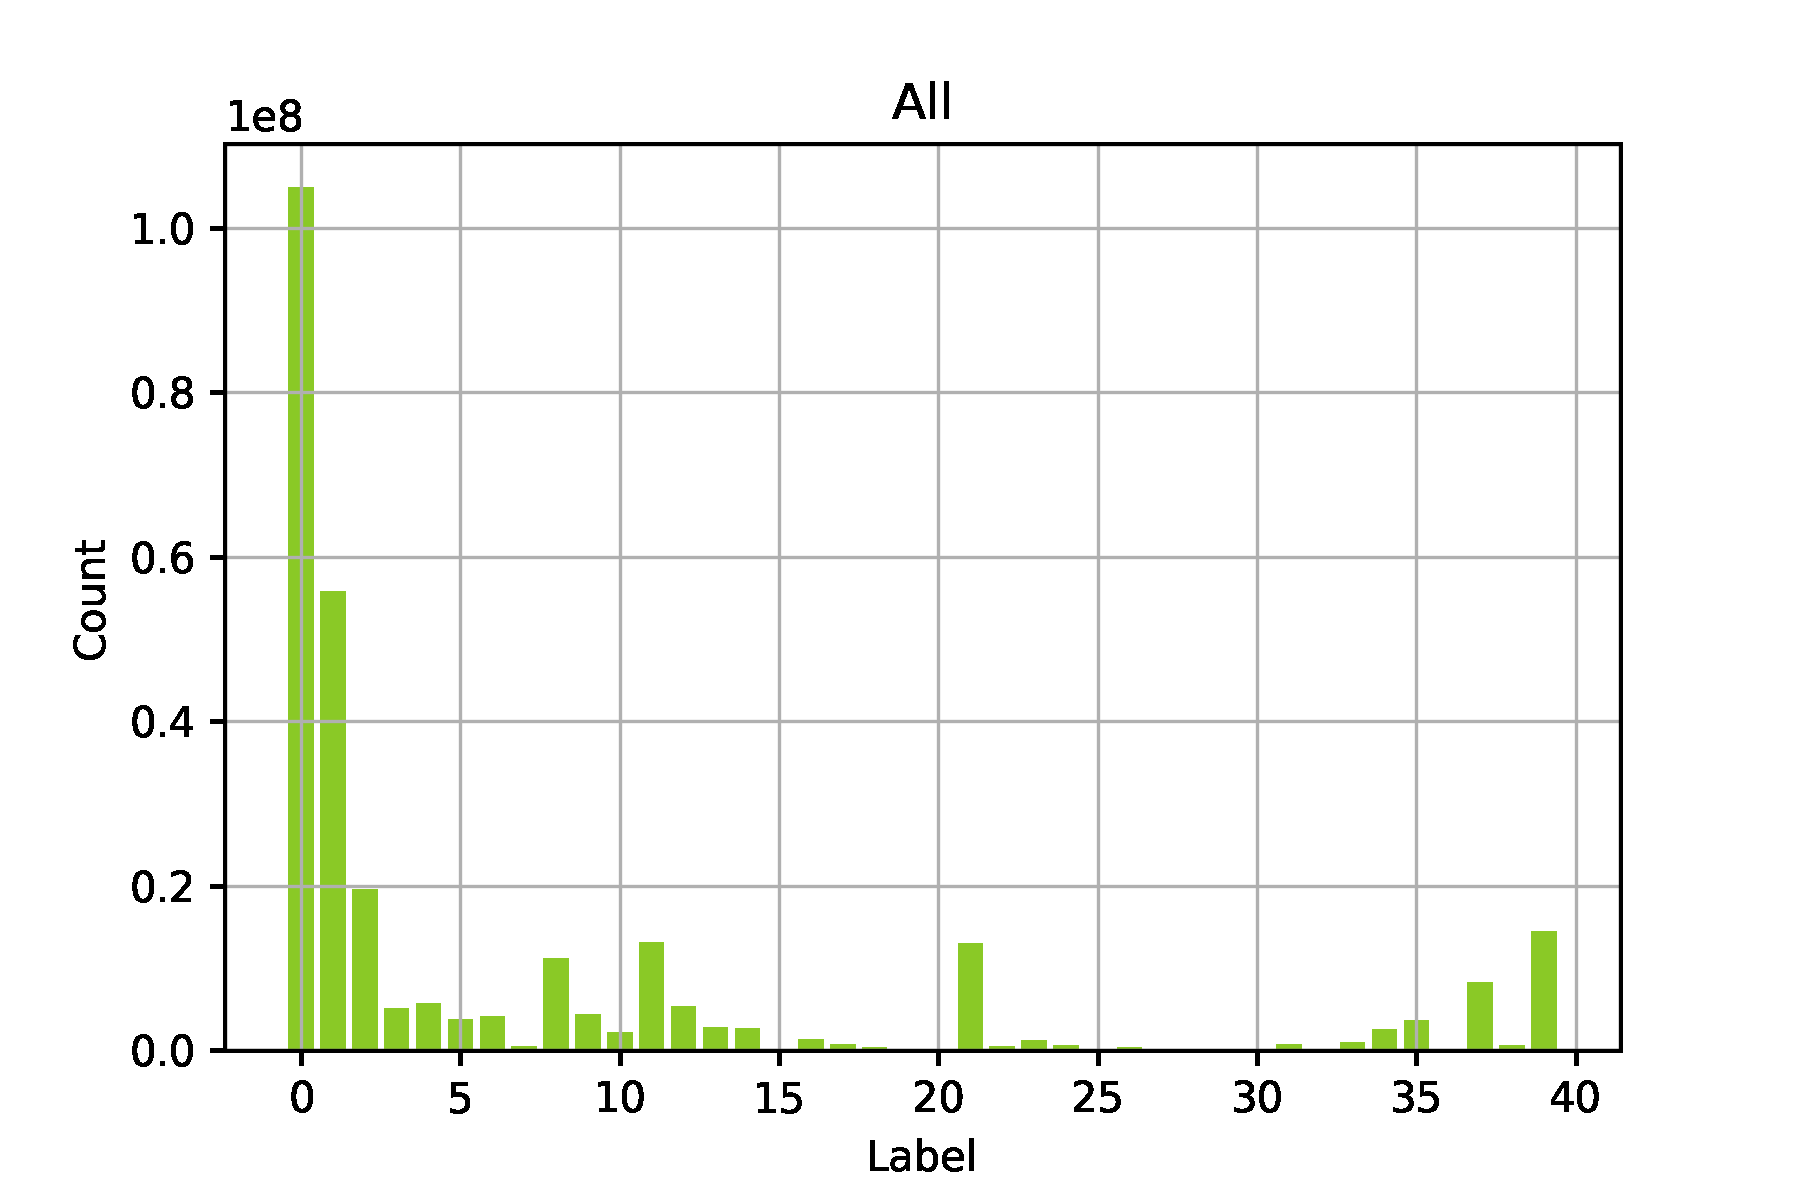

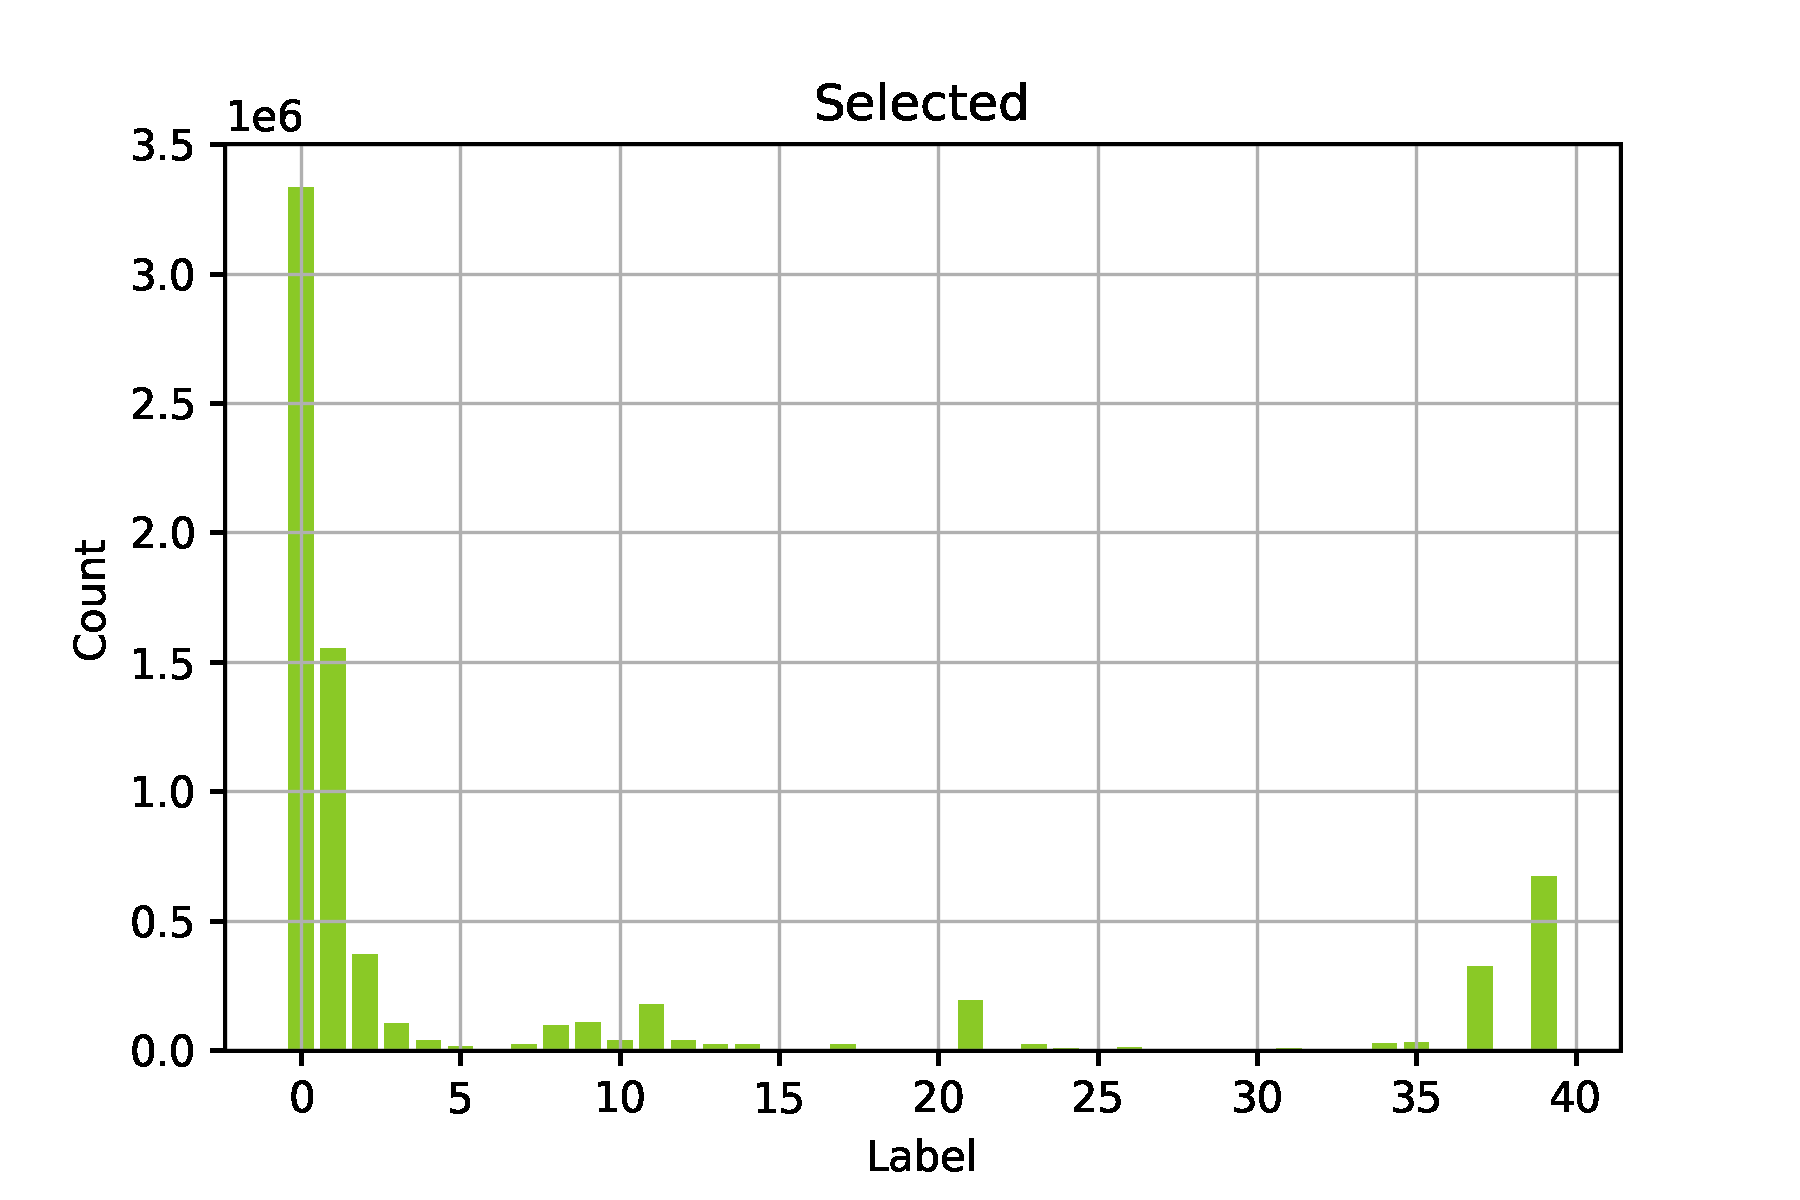

In [77]:

import torch 
import random
from random import randint
from torch.nn import functional as F


__all__ = ['interclass_dissimilarity']


def met_low_distance(candidate, buffer , l2=True):
    """
    candidate_feature: 128 dimensional
    buffer_features: Nx128 all features from the targeted classes
    """
    if l2:
        inp = candidate[None,:].repeat(buffer.shape[0],1).type(torch.float32) - buffer[:,:].type(torch.float32)
        metric = torch.norm(inp, p=2, dim=1)
    else:
        metric = F.cosine_similarity(
            candidate[None,:,None].repeat(buffer.shape[0],1,1).type(torch.float32), 
            buffer[:,:,None].type(torch.float32),
            dim=1, eps=1e-6) 
    return metric.min()


def compute_interclass_similarity_score(candidate_features, buffer_features_all):
    """
    buffer_features: NBxCx128  
    
    for each class:
        - find where it appreas in the buffer
        - for each sample in each class get the distance to the closest neighbour
        - average over this "minimal class distance"
        - return the average distance achieved
        
    - if only one element of this in the buffer:
        - set the achieved interclass distance to average values of the other classes
        - if set to 0 we favour two examples or more
        - if set to max(of other classes) we favor using a single element which is undisirable aswell
    
    """
    buffer_features_all = torch.cat( [candidate_features[None],buffer_features_all], dim=0)
    m = buffer_features_all.sum(dim=2) != 0
    
    score = 0
    add_average_times = 0 
    
    per_class_overview = {}
    for i in range( buffer_features_all.shape[1] ):
         
        
        m1 = m[:,i]
        nr_possible_comparision = m1.sum()
        if nr_possible_comparision < 2:
            add_average_times += 1
            continue
        
        feat = buffer_features_all[:,i, :]
        indi = torch.nonzero(m1)
        val = 0
        for j in indi:
            m_buffer = m1.clone()
            m_buffer[j] = False
            lowest_d = met_low_distance(candidate= feat[j][0], buffer = feat[m_buffer] )
            val = val + lowest_d 
        
        score += val / indi.shape[0]
        
        per_class_overview[str(i)] = val / indi.shape[0]
    # print("per class overview", per_class_overview)
    mean = score /  (buffer_features_all.shape[1]-add_average_times)
    
    # if we dont add the mean we motivate to at least keep two samples of each class in the buffer
    res = score # + mean * add_average_times
    return res

def interclass_dissimilarity(latent_features, label_dist, K_return=50, iterations= 1000, early_stopping = 0.00001):
    """ returns k indexe from globale_indices
    Implements sampling based metric optimization
    
    
    Parameters
    ----------
    latent_features: torch.tensor NRxCx128 
    label_dist : torch.tensor NRxC
    K_return : int, optional
            number of returned indices, by default 50
    """
    
    init_selection = torch.randperm( latent_features.shape[0] )[:K_return]
    buffer_features_all = latent_features[init_selection,:,:]
    
    prev_score = 0
    for i in range(iterations):
        swap_candidate = torch.randint(0,K_return, (1,))
        while True:
            replacement_candidate = torch.randint(0,latent_features.shape[0],(1,))[0]
            if replacement_candidate not in init_selection:
                break
        buffer_mask = torch.ones( (K_return)  ,dtype=bool)
        buffer_mask[swap_candidate] = False
        
        new_score = compute_interclass_similarity_score( 
            latent_features[replacement_candidate], 
            buffer_features_all[buffer_mask] )
        ra = random.random()
        
        if new_score > prev_score or  ra > 0.995:
            # apply change
            init_selection[swap_candidate] = int(replacement_candidate)
            buffer_features_all[swap_candidate] = latent_features[replacement_candidate]
            prev_score = new_score
            print(prev_score)
            
    return init_selection, prev_score


def test():
    
    nr = torch.randint(0,10,(128,)).type(torch.float32)
    nr2 = torch.randint(0,10,(100, 128)).type(torch.float32)
    met_low_distance( nr, nr2) 
    
    nr = torch.randint(0,10,(40,128)).type(torch.float32)
    nr2 = torch.randint(0,10,(50,40, 128)).type(torch.float32)        
    compute_interclass_similarity_score(nr,nr2) 
    
    from PIL import Image
    import os, sys
    
    import time
    
    os.chdir('/home/jonfrey/ASL')
    sys.path.append('/home/jonfrey/ASL')
    sys.path.append('/home/jonfrey/ASL/src')
    from visu import Visualizer
    
    vis = Visualizer('/home/jonfrey/tmp', logger=None, epoch=0, store=True, num_classes=41)

    label_dist = torch.load( '/media/scratch1/jonfrey/models/master_thesis/dev/uncertainty_integration3/labels_tensor_0.pt')
    globale_indices = torch.load( '/media/scratch1/jonfrey/models/master_thesis/dev/uncertainty_integration3/indices_tensor_0.pt')
    latent_features = torch.load( '/media/scratch1/jonfrey/models/master_thesis/dev/uncertainty_integration3/latent_feature_tensor_0.pt')
    
    st = time.time()
    selected, metric = interclass_dissimilarity(latent_features, label_dist, iterations= 5000)
    
    selected_globale_indices = globale_indices[selected]

    t =  time.time()-st
    print(selected.sum(), metric, 'Total time',t)                 

    res = vis.plot_bar(label_dist.sum(dim=0), x_label='Label', y_label='Count',
            sort=False, reverse=True, title= 'All', 
            tag=f'Pixelwise_Class_Count_Task', method='left',jupyter=True)
    display(Image.fromarray(res))

    res = vis.plot_bar(label_dist[selected,:].sum(dim=0), x_label='Label', y_label='Count',
            sort=False, reverse=True, title= 'Selected',
            tag=f'Pixelwise_Class_Count_Task', method='left',jupyter=True)
    display(Image.fromarray(res))

test()  